# Medical Embeddings and Clinical Trial Search Engine

- Resources:
    - [Gensim Documentation - Explore it! - It seems pretty good](https://radimrehurek.com/gensim/auto_examples/index.html)
    
    - [Streamlit documentation](https://docs.streamlit.io/)

## Imports 

In [1]:
import os
import streamlit as st

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

import gensim
from gensim.models import Word2Vec, FastText

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go

import string # used for preprocessing
import re # used for preprocessing

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords       # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Amit Vikram
[nltk_data]     Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Amit Vikram
[nltk_data]     Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Amit Vikram
[nltk_data]     Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importing Datasets 

In [2]:
df = pd.read_csv("Data/Dimension-covid.csv")

## Data Preprocessing

Steps:
- **Cleaning the text data**
    - Stripping unwanted characters like puntuation or other non-letter characters
    

- **Tokenization**
    - Tokenization is the process of tokenizing or splitting a string, text into a list of tokens. One can think of token as parts like a word is a token in a sentence, and a sentence is a token in a paragraph.
    
- **Stemming/Lemmatization**
    - Converting a word into it's root form.
    
    - Stemming identifies the common root form of a word by removing or replacing word suffixes (e.g. “flooding” is stemmed as “flood”), while lemmatization identifies the inflected forms of a word and returns its base form (e.g. “better” is lemmatized as “good”).
    
    - Lemmatization is computationally more difficult and expensive compared to stemming. However it is obsereved there is little impact on the performance of text classification so we can use any of them.
    

- **Stop Words Removal**
    - Commonly ocurring words in texts like ```is, and, has, like, etc..``` and probably bear no (or only a little) useful information that can be used to distinguish between different classes of documents.
    

In [3]:
df.shape

(10666, 21)

In [5]:
df.head(3)

,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date,Active years,Phase,Conditions,Intervention,Gender,Registry,Investigators/Contacts,Sponsors/Collaborators,GRID IDs,Country of Sponsor/Collaborator,Collaborating Funders,Funder Country,Source Linkout,Dimensions URL
0,2021-06-04,NCT04912934,The Relationship Between Coronavirus Anxiety L...,The Relationship Between COVID-19 Anxiety Leve...,COVID-19,The aim was to determine the coronavirus anxie...,2020-06-20,2020,NaN,COVID-19; Emotional Eating; Metabolic Syndrome,A survey form was applied to individuals inclu...,All,ClinicalTrials.gov,Dilek Küçük Alemdar,Ordu University,grid.412366.4,Turkey,NaN,NaN,https://clinicaltrials.gov/show/NCT04912934,https://app.dimensions.ai/details/clinical_tri...
1,2021-06-04,NCT04912921,Effect of Palmitoylethanolamide on Proinflamma...,Effect of Palmitoylethanolamide on Proinflamma...,NaN,This is a randomized controlled trial to exami...,2020-10-20,2020; 2021; 2022,NaN,COVID19; Inflammation,Placebo (Dietary Supplement); palmitoylethanol...,All,ClinicalTrials.gov,NaN,Arizona State University,grid.215654.1,United States,NaN,NaN,https://clinicaltrials.gov/show/NCT04912921,https://app.dimensions.ai/details/clinical_tri...
2,2021-06-04,NCT04912895,Detection of SARS-CoV-2 RNA and Biomarkers in ...,Detection of SARS-CoV-2 RNA in Coughed Droplet...,NaN,The purpose of this study is to learn how to b...,2021-04-14,2021; 2022,NaN,Covid19,PneumoniaCheck (Device),All,ClinicalTrials.gov,Larry Anderson,Emory University Hospital Midtown; Emory Unive...,grid.411929.6; grid.412162.2; grid.189967.8; g...,United States; United States; United States; U...,NaN,NaN,https://clinicaltrials.gov/show/NCT04912895,https://app.dimensions.ai/details/clinical_tri...


The following two columns are essential for us,
* Title
* Abstract

In [6]:
df['Title'][0]

'The Relationship Between Coronavirus Anxiety Level and Emotional Eating in Individuals With Metabolic Syndrome'

In [7]:
df['Abstract'][1000]

"This study is a randomized, double-blind, placebo-controlled trial to evaluate the efficacy of cetirizine and famotidine in reducing the duration of symptoms in patients with COVID-19. Secondary aims are to determine if cetirizine and famotidine decrease severity and duration of symptoms, incidence of hospitalizations, ICU admissions, and death.\n\nDetailed Description\nCOVID-19 is a disease caused by the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). Patients with COVID-19 may present with a myriad of symptoms ranging from fever and cough to more severe symptoms such as shortness of breath. Cetirizine and famotidine are commonly administered medications that can be found over-the-counter. They are well tolerated and have low potential for drug-drug interaction. With it's anti-inflammatory properties via modulation of proinflammatory cytokines, cetirizine may be an effective symptomatic therapeutic for COVID-19. With possible antiviral properties, famotidine may have a 

In [8]:
# lower-case the text
def text_lowercase(text: str):
    return text.lower()


# remove any urls in the text(if present)
def remove_urls(text: str):
    """
    Try the sample_text and pattern at https://regex101.com/ to understand it.
    
    pattern = (@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)
    
    sample_text = with virtual care, fear of vision loss, and change in vision during the pandemic as measured
                  using 5-point Likert scale multiple-choice format questionnaires. All questionnaires can 
                  be found at https://uwo.eu.qualtrics.com/jfe/form/SV_9ZiJmfKStrhabxH. STATISTICAL ANALYSIS AND 
                  SAMPLE SIZE Data analysis We will examine the descriptive statistics for the participants group 
                  and check for outliers. We plan to use a linear-mixed model
    """
    
    pattern = "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"
    new_text = " ".join(re.sub(pattern, " ", text, flags=re.MULTILINE).split())
    
    return new_text


# remove any numbers
def remove_numbers(text: str):
    new_text = re.sub(r'\d+', '', text)
    return new_text

# remove any puntuations
def remove_punctuation(text: str):
    """
    Reference:
    https://www.geeksforgeeks.org/python-maketrans-translate-functions/
    """
    translator = str.maketrans('', '', string.punctuation)
    
    return text.translate(translator)


# tokenize
def tokenize(text: str):
    text = word_tokenize(text)
    return text

# remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text: str):
    # text = [word for word in text if word not in stop_words]
    text = [word for word in text if not word in stop_words]
    return text


# lemmatize Words
lemmatizer = WordNetLemmatizer()
def lemmatize(text: str):
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

# Preprocessing
def preprocessing(text: str):
    # text = text.strip()
    
    # lower-case the text
    text = text_lowercase(text)
    
    # remove any urls in the text(if present)
    text = remove_urls(text)
    
    # remove any numbers
    text = remove_numbers(text)
    
    # remove any puntuations
    text = remove_punctuation(text)
    
    # tokenize
    text = tokenize(text)
    
    # remove stopwords
    text = remove_stopwords(text)
    
    # lemmatize
    text = lemmatize(text)
    
    text = " ".join(text)
    return text

In [9]:
# Preprocessing code Works!

# text = _
# for i in range(df.shape[0]):
#     if "https:" in df['Abstract'][i]:
#         text = df['Abstract'][i]
#         break
        
# preprocessing(text)

### Applying Preprocessing on ```Abstract``` column

In [10]:
# Applying preprocessing and removing '\n' character

df1 = df.copy()

for i in range(df1.shape[0]):
    text = str(df1['Abstract'][i])
    
    text = preprocessing(text)
    
    text = text.replace("\n", " ")
    
    df1['Abstract'].loc[i] = text

In [11]:
df1[['Abstract']].head(3)

,Abstract
0,aim determine coronavirus anxiety level emotio...
1,randomized controlled trial examine effect foo...
2,purpose study learn better detect infection un...


In [12]:
print("After Processing\n-----------------\n")
print(df1['Abstract'][0])

print("\n----------------------\nBefore Processing\n---------------\n")
print(df['Abstract'][0])

After Processing
-----------------

aim determine coronavirus anxiety level emotional eating status case diagnosis mets according diagnostic criterion published international diabetic federation idf healthy individual similar bmi mets subject detailed description aim determine coronavirus anxiety level emotional eating status case diagnosis mets according diagnostic criterion published international diabetic federation idf healthy individual similar bmi mets subject study completed descriptive cross sectional relational screening model full sampling method used study study completed individual metabolic syndrome attending diet clinic healthy individual without mets diagnosis also attending diet clinic collection data used anthropometric measurement biochemical finding blood pressure survey form coronavirus anxiety scale ca emotional eating scale ee

----------------------
Before Processing
---------------

The aim was to determine the coronavirus anxiety levels and emotional eating sta

### Applying Preprocessing on ```Title``` column

In [13]:
# Applying preprocessing and removing '\n' character

for i in range(df1.shape[0]):
    text = str(df1['Title'][i])
    
    text = preprocessing(text)
    
    text = text.replace("\n", " ")
    
    df1['Title'].loc[i] = text

In [14]:
print("After Processing\n-----------------\n")
print(df1['Title'][0])

print("\n----------------------\nBefore Processing\n---------------\n")
print(df['Title'][0])

After Processing
-----------------

relationship coronavirus anxiety level emotional eating individual metabolic syndrome

----------------------
Before Processing
---------------

The Relationship Between Coronavirus Anxiety Level and Emotional Eating in Individuals With Metabolic Syndrome


In [15]:
# Tokenizing data for training purpose
x = [word_tokenize(word) for word in df1.Abstract ] 

## Exploratory data analysis

In EDA we are exploring the most common words in the corpus

In [16]:
from collections import Counter

cnt = Counter()

for text in df1['Abstract'].values:
    for word in text.split():
        cnt[word] += 1
        

# Top 10 common words
cnt.most_common(10)

[('patient', 38457),
 ('covid', 38211),
 ('study', 31963),
 ('group', 12771),
 ('treatment', 12471),
 ('day', 12337),
 ('sars', 11600),
 ('cov', 11535),
 ('clinical', 11507),
 ('disease', 11395)]

This is a medical dataset related to COVID and clearly we can see the most common words as ```patient, covid, sars,```etc..

In [17]:
# !pip install wordcloud

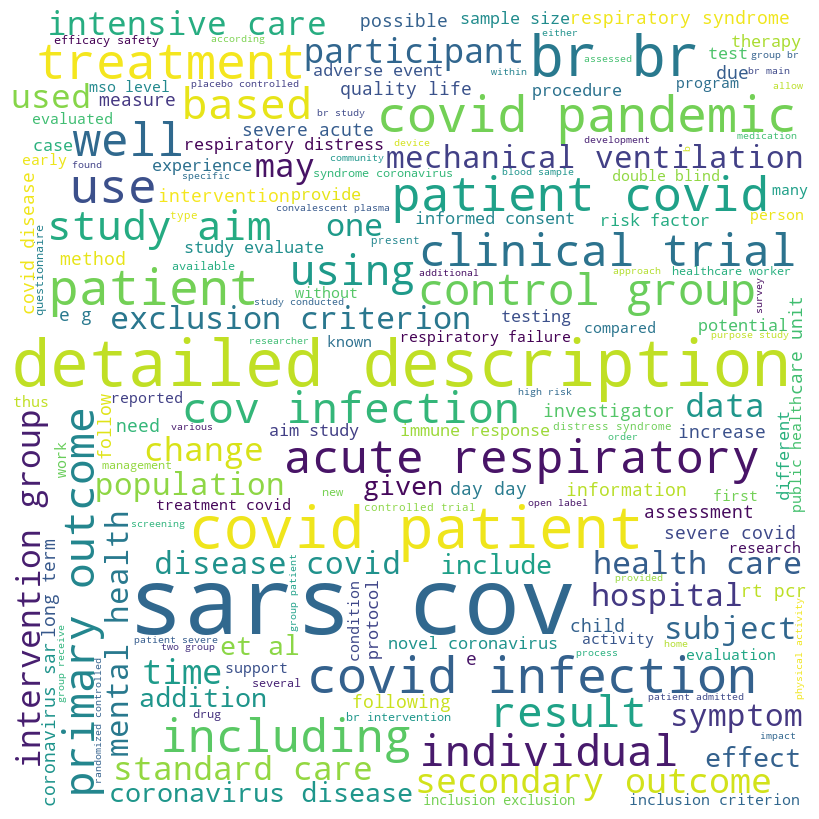

In [18]:
# Final word cloud after all the cleaning and pre-processing

from wordcloud import WordCloud, STOPWORDS
from textwrap import wrap

from pandas.core.common import flatten
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

# iterate through the csv file
comment_words = flatten(x)
comment_words = ' '.join(comment_words)

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)


# plot the wordcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show();

## Training Models

### SkipGram Model 

In [19]:
# ?Word2Vec

In [20]:
# Train ing the model

import os
from gensim.models import Word2Vec

skipgram = Word2Vec(sentences=x, vector_size=50, window=3, min_count=2, sg=1)

'''
Here:
    x = is our dataset that we prepared after preprocessing
    vector_size = size of the vector for each word
    window = the window size for context words
    min_count = only those words that has appeared atleast 2 times in the corpus
    sg : {0, 1}, optional
         Training algorithm: 1 for skip-gram; otherwise CBOW
'''

print(skipgram)

# Saving the model

if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

skipgram.save('saved_models/skipgram_50.bin')

2023-04-17 07:12:07.594 INFO    gensim.models.word2vec: collecting all words and their counts
2023-04-17 07:12:07.595 INFO    gensim.models.word2vec: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-04-17 07:12:07.886 INFO    gensim.models.word2vec: PROGRESS: at sentence #10000, processed 2024809 words, keeping 39392 word types
2023-04-17 07:12:07.895 INFO    gensim.models.word2vec: collected 39969 word types from a corpus of 2088009 raw words and 10666 sentences
2023-04-17 07:12:07.896 INFO    gensim.models.word2vec: Creating a fresh vocabulary
2023-04-17 07:12:07.977 INFO    gensim.utils: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 24877 unique words (62.24% of original 39969, drops 15092)', 'datetime': '2023-04-17T07:12:07.977389', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2023-04-17 07:12:0

Word2Vec<vocab=24877, vector_size=50, alpha=0.025>


In [21]:
# training another skipgram model with vector_size=100 & window=1

skipgram = Word2Vec(sentences=x, vector_size=100, 
                    window=1, min_count=2, sg=1)

print(skipgram)

# Saving the model
os.makedirs('saved_models', exist_ok=True)

skipgram.save("saved_models/skipgram_100.bin");

2023-04-17 07:12:21.882 INFO    gensim.models.word2vec: collecting all words and their counts
2023-04-17 07:12:21.882 INFO    gensim.models.word2vec: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-04-17 07:12:22.093 INFO    gensim.models.word2vec: PROGRESS: at sentence #10000, processed 2024809 words, keeping 39392 word types
2023-04-17 07:12:22.103 INFO    gensim.models.word2vec: collected 39969 word types from a corpus of 2088009 raw words and 10666 sentences
2023-04-17 07:12:22.104 INFO    gensim.models.word2vec: Creating a fresh vocabulary
2023-04-17 07:12:22.185 INFO    gensim.utils: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 24877 unique words (62.24% of original 39969, drops 15092)', 'datetime': '2023-04-17T07:12:22.185070', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2023-04-17 07:12:2

Word2Vec<vocab=24877, vector_size=100, alpha=0.025>


In [22]:
# Loading the model

skipgram = Word2Vec.load('saved_models/skipgram_100.bin')

2023-04-17 07:12:30.096 INFO    gensim.utils: loading Word2Vec object from saved_models/skipgram_100.bin
2023-04-17 07:12:30.113 INFO    gensim.utils: loading wv recursively from saved_models/skipgram_100.bin.wv.* with mmap=None
2023-04-17 07:12:30.114 INFO    gensim.utils: setting ignored attribute cum_table to None
2023-04-17 07:12:30.258 INFO    gensim.utils: Word2Vec lifecycle event {'fname': 'saved_models/skipgram_100.bin', 'datetime': '2023-04-17T07:12:30.258896', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'loaded'}


### FastText Model

In [22]:
# ?FastText

In [23]:
from gensim.models import FastText

fast_n = FastText(sentences=x, vector_size=200, window=3,
                  min_count=2, workers = -1, 
                  min_n = 1, max_n=2, sg = 1)

'''
Since fasttext model takes character as input:
    min_n = 1, max_n = 2 --> tells how many characters to feed into the model
    
    workers = -1 --> All cores will be used
'''

# Saving the model
os.makedirs("saved_models", exist_ok=True)

fast_n.save("saved_models/fast_text_200.bin")

2023-04-17 07:12:31.720 INFO    gensim.models.word2vec: collecting all words and their counts
2023-04-17 07:12:31.721 INFO    gensim.models.word2vec: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-04-17 07:12:31.933 INFO    gensim.models.word2vec: PROGRESS: at sentence #10000, processed 2024809 words, keeping 39392 word types
2023-04-17 07:12:31.941 INFO    gensim.models.word2vec: collected 39969 word types from a corpus of 2088009 raw words and 10666 sentences
2023-04-17 07:12:31.942 INFO    gensim.models.word2vec: Creating a fresh vocabulary
2023-04-17 07:12:32.026 INFO    gensim.utils: FastText lifecycle event {'msg': 'effective_min_count=2 retains 24877 unique words (62.24% of original 39969, drops 15092)', 'datetime': '2023-04-17T07:12:32.026245', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2023-04-17 07:12:3

In [24]:
# Loading the model

fast_n = Word2Vec.load("saved_models/fast_text_200.bin")

2023-04-17 07:12:36.793 INFO    gensim.utils: loading Word2Vec object from saved_models/fast_text_200.bin
2023-04-17 07:12:36.813 INFO    gensim.utils: loading wv recursively from saved_models/fast_text_200.bin.wv.* with mmap=None
2023-04-17 07:12:36.814 INFO    gensim.utils: loading vectors_ngrams from saved_models/fast_text_200.bin.wv.vectors_ngrams.npy with mmap=None
2023-04-17 07:12:37.311 INFO    gensim.utils: setting ignored attribute buckets_word to None
2023-04-17 07:12:37.313 INFO    gensim.utils: setting ignored attribute vectors to None
2023-04-17 07:12:37.853 INFO    gensim.utils: setting ignored attribute cum_table to None
2023-04-17 07:12:38.043 INFO    gensim.utils: FastText lifecycle event {'fname': 'saved_models/fast_text_200.bin', 'datetime': '2023-04-17T07:12:38.043731', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'loaded'}


In [25]:
# Training another model

fasttext = FastText(sentences=x, vector_size=100,
                    min_count=2, workers=-1,
                    min_n=1, max_n=2, sg=1)

fasttext.save("saved_models/fast_text_100.bin")

2023-04-17 07:12:41.543 INFO    gensim.models.word2vec: collecting all words and their counts
2023-04-17 07:12:41.544 INFO    gensim.models.word2vec: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-04-17 07:12:41.759 INFO    gensim.models.word2vec: PROGRESS: at sentence #10000, processed 2024809 words, keeping 39392 word types
2023-04-17 07:12:41.768 INFO    gensim.models.word2vec: collected 39969 word types from a corpus of 2088009 raw words and 10666 sentences
2023-04-17 07:12:41.769 INFO    gensim.models.word2vec: Creating a fresh vocabulary
2023-04-17 07:12:41.859 INFO    gensim.utils: FastText lifecycle event {'msg': 'effective_min_count=2 retains 24877 unique words (62.24% of original 39969, drops 15092)', 'datetime': '2023-04-17T07:12:41.859284', 'gensim': '4.3.0', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2023-04-17 07:12:4

## Model embeddings - Similarity

### SkipGram

The trained word vectors are stored in a ```KeyedVectors``` instance, as ```model.wv```

In [64]:
skipgram.wv.index_to_key  # List of all words in list

skipgram.wv.key_to_index # List of all word in dict

len(skipgram.wv.index_to_key)

24877

In [104]:
skipgram.wv.index_to_key[:10]

['patient',
 'covid',
 'study',
 'group',
 'treatment',
 'day',
 'sars',
 'cov',
 'clinical',
 'disease']

In [115]:
import itertools

word_dict = skipgram.wv.key_to_index
dict(itertools.islice(word_dict.items(), 10))

{'patient': 0,
 'covid': 1,
 'study': 2,
 'group': 3,
 'treatment': 4,
 'day': 5,
 'sars': 6,
 'cov': 7,
 'clinical': 8,
 'disease': 9}

In [107]:
# Getting of vector representation of a word

skipgram.wv['india'].shape, skipgram.wv['india']

((100,),
 array([-0.11534848,  0.55769026,  0.1105921 , -0.20178337, -0.61222893,
        -0.8009126 , -0.20910457,  1.0633696 ,  0.35423976, -0.1629082 ,
        -0.35157827, -0.65564007,  0.06209129, -0.2838537 , -0.3299153 ,
        -0.16191639, -0.23826402,  0.15511027,  0.18033291,  0.03732924,
         0.05140328,  0.53765255, -0.08495924,  0.2035569 , -0.30515873,
        -0.08254984,  0.08466223,  0.08473176, -0.45314738,  0.30090675,
         0.14716682, -0.12742618,  0.38367814,  0.25734055, -0.26978448,
         0.37775406,  0.08784492, -0.2960762 , -0.06107137, -0.12816077,
         0.17619842, -0.2737948 ,  0.40204883,  0.18222447,  0.520806  ,
         0.36478618, -0.33938465,  0.16840953, -0.3286208 ,  0.20522514,
         0.30581272, -0.01915997, -0.20846519, -0.91701186, -0.2746452 ,
        -0.26322678,  0.38803557, -0.20692848, -0.3151772 , -0.32829395,
         0.48032442, -0.20547187,  0.27065998,  0.71758753, -0.28732982,
         0.8331352 ,  0.67532486,  0.36708

In [86]:
# Word Similarity: Compute cosine similarity between two keys.
pairs = [
    ('coronavirus', 'covid'),   
    ('coronavirus', 'covid19'),   
    ('coronavirus', 'sars'),  
    ('coronavirus', 'death'),    
    ('coronavirus', 'vaccine'),
    ('coronavirus', 'pandemic'),
    ('coronavirus', 'disease'),
    ('coronavirus', 'italy'),
    ('coronavirus', 'china'),
    ('coronavirus', 'india'),
]

for w1, w2 in pairs:
    try:
        print('%r\t%r : %.2f' % (w1, w2, skipgram.wv.similarity(w1, w2)))
    except Exception as e:
        print(f"\n{w2} not present in corpus")
        print(e,"\n")

'coronavirus'	'covid' : 0.65

covid19 not present in corpus
"Key 'covid19' not present" 

'coronavirus'	'sars' : 0.68
'coronavirus'	'death' : 0.34
'coronavirus'	'vaccine' : 0.31
'coronavirus'	'pandemic' : 0.49
'coronavirus'	'disease' : 0.46
'coronavirus'	'italy' : 0.43
'coronavirus'	'china' : 0.55
'coronavirus'	'india' : 0.44


**Unfortunately, the model is unable to infer vectors for unfamiliar words. This is one limitation of Word2Vec**: if this limitation matters to you, check out the FastText model.

In [80]:
try:
    vec_Italy = skipgram.wv['namaste']
except KeyError:
    print("The word 'namaste' does not appear in this model")

The word 'namaste' does not appear in this model


In [92]:
# Print the 5 most similar words to 'china' or 'death'

skipgram.wv.most_similar(positive=['corona', 'death'], topn=5)

[('novelty', 0.7557163834571838),
 ('nonetheless', 0.7500195503234863),
 ('sari', 0.7477384805679321),
 ('fatality', 0.746427595615387),
 ('covd', 0.7454772591590881)]

In [26]:
# Similar words - skipgram

skipgram.wv.most_similar(positive=['corona'], topn=10)

[('coronavirus', 0.752761960029602),
 ('covid', 0.7045067548751831),
 ('novelty', 0.6903101205825806),
 ('evd', 0.6867043972015381),
 ('crown', 0.6799406409263611),
 ('ebola', 0.6747689843177795),
 ('declares', 0.6683897376060486),
 ('betacoronavirus', 0.6639927625656128),
 ('virulent', 0.6632217764854431),
 ('myasthenic', 0.6596984267234802)]

In [27]:
skipgram.wv.most_similar(positive=['patient'], topn=10)

[('hospitalised', 0.7486473321914673),
 ('subject', 0.7427707314491272),
 ('acutely', 0.7331638336181641),
 ('participant', 0.7278004288673401),
 ('individual', 0.7277425527572632),
 ('moderately', 0.7194323539733887),
 ('recovering', 0.7116544842720032),
 ('survivor', 0.6966630816459656),
 ('pwcf', 0.6918379664421082),
 ('lymphocytopenia', 0.69087153673172)]

### FastText

In [93]:
for w1, w2 in pairs:
    try:
        print('%r\t%r : %.2f' % (w1, w2, fasttext.wv.similarity(w1, w2)))
    except Exception as e:
        print(f"\n{w2} not present in corpus")
        print(e,"\n")

'coronavirus'	'covid' : 0.46
'coronavirus'	'covid19' : 0.26
'coronavirus'	'sars' : 0.49
'coronavirus'	'death' : 0.01
'coronavirus'	'vaccine' : 0.22
'coronavirus'	'pandemic' : 0.24
'coronavirus'	'disease' : 0.21
'coronavirus'	'italy' : 0.10
'coronavirus'	'china' : 0.17
'coronavirus'	'india' : 0.16


In [96]:
fasttext.wv.most_similar(positive=['corona', 'death'], topn=10)

[('anticorona', 0.6930738687515259),
 ('northcards', 0.6726279258728027),
 ('conversational', 0.6555589437484741),
 ('strathclyde', 0.6460632085800171),
 ('atherothrombosis', 0.6436590552330017),
 ('carolina', 0.6432142853736877),
 ('dearth', 0.642473578453064),
 ('atherosclerotic', 0.6388640999794006),
 ('collaborative', 0.6382637619972229),
 ('throat', 0.6382423639297485)]

In [29]:
# Similar words - fasttext

fasttext.wv.most_similar(positive=['lung'], topn=10)

[('blunting', 0.7701619267463684),
 ('ltigung', 0.7395897507667542),
 ('leung', 0.7326470613479614),
 ('hung', 0.7192775011062622),
 ('unwilling', 0.7082127928733826),
 ('long', 0.6991294026374817),
 ('lungiq', 0.6957274079322815),
 ('laung', 0.6932936310768127),
 ('lang', 0.6844402551651001),
 ('unlocking', 0.6691715717315674)]

In [30]:
fasttext.wv.most_similar(positive=['breathing'], topn=10)

[('rebreathing', 0.8758812546730042),
 ('breath', 0.8046075701713562),
 ('breaching', 0.7950540781021118),
 ('threatening', 0.7787477970123291),
 ('breathable', 0.7583754658699036),
 ('breaking', 0.7475854754447937),
 ('gathering', 0.7410953044891357),
 ('breathe', 0.7297273874282837),
 ('moderating', 0.7292203903198242),
 ('bathing', 0.726135790348053)]

**It seems that Word Similarity is better in SkipGram**

## PCA Plots


### SkipGram 

In [97]:
X = skipgram.wv[skipgram.wv.index_to_key] # storing arrays of all words

pca = PCA(n_components=2)   # applying PCA to convert data in 2 dimensions
result = pca.fit_transform(X)

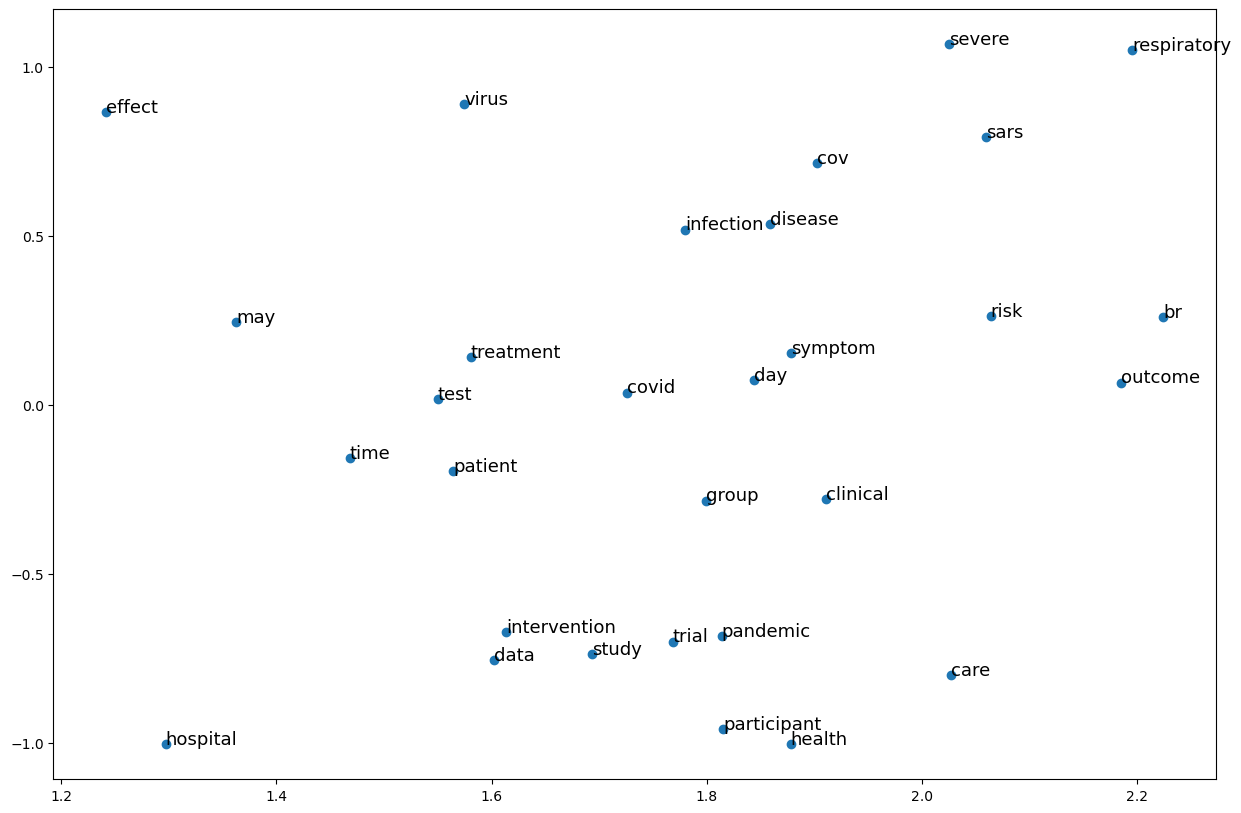

In [98]:
# Word embedding on the plot to check 2D-rep. of each word

plt.figure(figsize=(15,10))
plt.scatter(result[:30, 0], result[:30, 1])

words = list(skipgram.wv.index_to_key)
for i, word in enumerate(words[:30]):
    plt.annotate(word, xy=(result[i,0], result[i,1]), fontsize=13)

plt.show();

### FastText

In [99]:
X_fast = fasttext.wv[fasttext.wv.index_to_key]

pca = PCA(n_components=2)
result_fast = pca.fit_transform(X_fast)

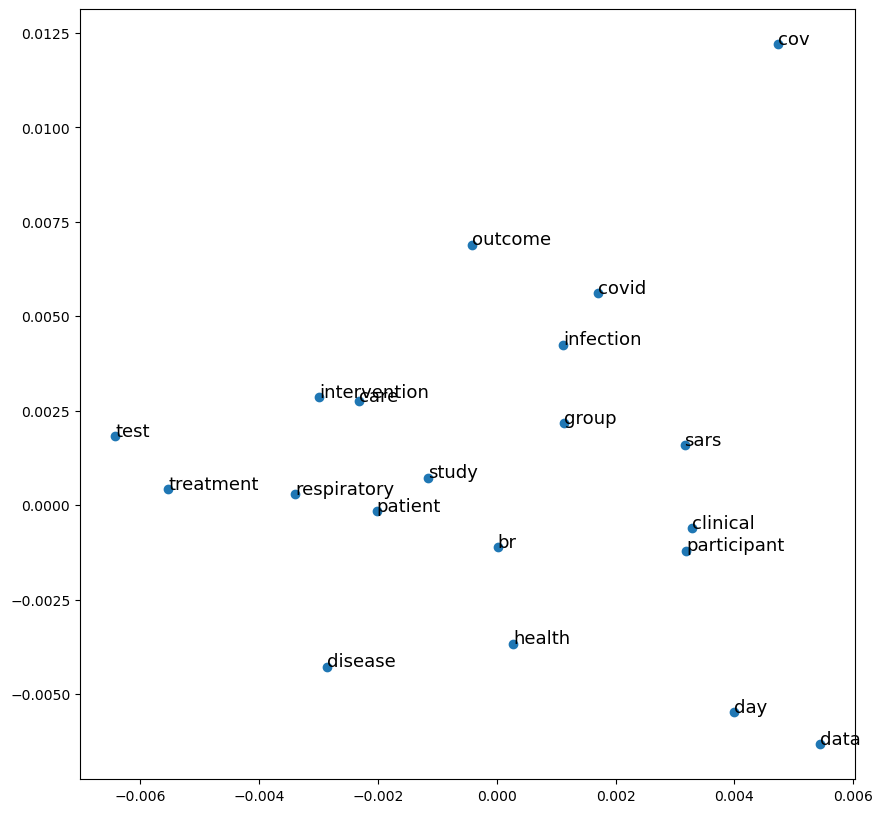

In [100]:
plt.figure(figsize=(10,10))
plt.scatter(result_fast[:20, 0], result_fast[:20, 1])

words = list(fasttext.wv.index_to_key)
for i, word in enumerate(words[:20]):
    plt.annotate(word, xy=(result_fast[i, 0], result_fast[i,1]), fontsize=13)
    
plt.show();

## Getting Vectors for Each Abstract

In [121]:
vector_size = 100 # defining vector size for each word

Basically below what we are doing is:

- From the Word2Vec model we have vector representation of each word in the whole corpus
    
- Now, we want vector representation of each "Abstract" i.e each sentence(row) of the DataFrame

- So, for that what we are doing is:

    - We are summing the vect. rep. of each word in that sentence and averaging it out to get the vect. rep. of the sentence

### Method 1


In [74]:
%%time

# Function to take average of all vectors of each word in each abstract, so that 
# each abstract represent (1,100) dimensional vector

# Creating a list to store vector representation of each abstract
K1 = []  

# iterating through all the abstracts in the dataset
for i in range(df1.shape[0]):
    K = np.zeros([vector_size, 1]) # Creating an empty array of size (vec_size,1) to add vector representation of each word
    count = 0                      # Creating a count to check how many words are used from the abstract
    
    # iterating through all the abstracts in the dataset
    for word in word_tokenize(df1['Abstract'][i]):  
        if word in list(fasttext.wv.index_to_key):
            # if the word exists in the model vocab, increase count by 1 & add array of the given word
            count += 1
            K += fasttext.wv[word].reshape(vector_size, 1)
    # taking average of given array
    K=K/count                                               
    K1.append(list(K))

K1_array = np.array(K1)
K1_array = K1_array.reshape(df1.shape[0], vector_size) # Converting into array of shape (# of rows, vector_size)

CPU times: total: 3min 7s
Wall time: 7min 3s


### Method 2

* Method 1 will take time to run. Method 2 is prefered. 

In [117]:
def get_mean_vector(model, words):
    # remove out-of-vocabulary words
    words = [word for word in tokenize(words) if word in list(model.wv.index_to_key)] # if word in model vocab
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.array([0]*vector_size)

#### Abstract to vectors using skipgram Model

In [118]:
%%time

#defining empty list
K1 = []    

for i in df1.Abstract:
    K1.append(list(get_mean_vector(skipgram, i)))     #appending array to the list
    

# transposing the dataframe so that each vectors is represented vertically(column-wise)
K11 = pd.DataFrame(K1).transpose()    

# Saving vectors of each abstract in data frame so that we can use directly while running code again

K11.to_csv('Data/skipgram-vec.csv', index=False)

CPU times: total: 2min 38s
Wall time: 2min 45s


In [177]:
# Loading our pretrained vectors of each abstract
K = pd.read_csv('Data/skipgram-vec.csv')

# transforming dataframe into required array like structure as we did in above step
skipgram_vectors = []
for i in range(df1.shape[0]):
    skipgram_vectors.append(K[str(i)].values)

#### For converting Title into vectors using skipgram

In [122]:
%%time

K1_title = []
for i in df1.Title:
    K1_title.append(list(get_mean_vector(skipgram, i)))
    
K1_title = pd.DataFrame(K1).T

# Saving vectors of each abstract in data frame so that we can use directly while running code again
K1_title.to_csv('Data/skipgram-vec-title.csv', index=False)  

CPU times: total: 12.9 s
Wall time: 13.1 s


In [178]:
# Loading our pretrained vectors of each title
K = pd.read_csv(r'Data/skipgram-vec-title.csv')

skipgram_titles = []
for i in range(df1.shape[0]):
    skipgram_titles.append(K[str(i)].values)

#### Abstract to vector using FastText

In [102]:
%%time

K_fast = []

for i in df1.Abstract:
    K_fast.append(list(get_mean_vector(fasttext, i)))

K11 = pd.DataFrame(K_fast).T
K11.to_csv('Data/fastText-vec.csv', index=False)

CPU times: total: 4min 44s
Wall time: 6min 13s


In [179]:
#Loading our pretrained vectors of each abstract
data = pd.read_csv('Data/fastText-vec.csv')

#transforming dataframe into required array like structure as we did in above step
fast_vectors = []

for i in range(df.shape[0]):
    fast_vectors.append(data[str(i)].values)

## Cosine similarity function

**Def:** 

Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used to measure document similarity in text analysis.


![cosine_sim](https://www.tyrrell4innovation.ca/wp-content/uploads/2021/06/rsz_jenny_du_miword.png)


- OK Let’s see how to interprete !!


![](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg)


- **If result show that equal 1** 
    - that’s means 2 vectors are in the same line they have 0 degree angle with together
    - Very Similar Vectors

- **If result show that equal 0** 
    - that’s means 2 vectors are not in the same line they have 90 degree angle with together
    - Not Similar Vectors

- **If result show that equal -1** 
    - that’s means 2 vectors are in the same line but they are 180 degree angle with together one vector is the oppsite with another vector

In [125]:
from numpy.linalg import norm
from numpy import dot


def cos_sim(a,b):
    """
    In our context:
        a: Vector 'a' represents emebedding/vector rep. of query passed
        b: The average vector of each abstract in our dataset
        
        So, we need to find cosine dist. b/w then to see how similar they are.
    """
    return dot(a,b)/(norm(a)*norm(b))

In [107]:
cos_sim([1,0], [0,1])

0.0

In [108]:
cos_sim([1,1],[1,1])

0.9999999999999998

In [109]:
cos_sim([1,1], [-1,-1])

-0.9999999999999998

In [129]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

cosine_similarity([[1,1]], [[-1,-1]]),\
cosine_distances([[1,1]], [[-1,-1]])

# Cosine distance is defined as 1.0 minus the cosine similarity.

(array([[-1.]]), array([[2.]]))

In [130]:
cosine_similarity([[1,1]],[[1,1]])

array([[1.]])

## Input Query Preprocessing

In [131]:
def preprocessing_input(query, model):
    """
    We are providing query to analyze and the trained model to get it's vector rep.
    """
    query = preprocessing(query)
    query = query.replace("\n", ' ')
    K = get_mean_vector(model, query)
    
    return K

## Function to return 'n' similar results

In [128]:
# to display full text from each column
pd.set_option("display.max_colwidth", None) 

In [207]:
#function to return top n similar results

#query - input query
# abs_vectors - vectors for all abstracts
# df - original

def top_n(n, query, model, abs_vectors, df):
    """
    Function to return top n similar results

    n - to get top n
    query - input query
    model - trained model
    abs_vectors - average vectors for all abstracts obtained from the model
    df - original dataset
    """
    # n = int(input("Enter a integer value for n: "))
    print("\nQuery:",query,"\n")
    
    query = preprocessing_input(query, model)
    
    # Converting cosine similarities of overall dataset with i/p querie(s) into List
    query_cos_sim = []
    
    for idx,abs_vec in enumerate(abs_vectors):
        # Also appending there index
        tup = (cos_sim(query, abs_vec), idx)
        query_cos_sim.append(tup)
        
    
    # Sort list in descending order based on cosine values
    top_n_dist_values = sorted(query_cos_sim, reverse=True)[:n]
    
    # index_of_similar_abstract
    idxs = [i[-1] for i in top_n_dist_values]
    
    # cosine values
    cosine_vals = [i[0] for i in top_n_dist_values]
    
    print(cosine_vals)
    
    # returning dataframe (id, title,abstract ,publication date)
    return df.iloc[idxs, [1,2,5,6]], cosine_vals  

### Result Evaluation

In [210]:
# SkipGram model

query = "kidney" # "breathing"
n = 10
df = pd.read_csv("Data/Dimension-covid.csv")


results, cosine_values = top_n(n=5, query='lung faliure', 
                               model=skipgram, 
                               abs_vectors=skipgram_vectors,
                               df=df)

results


Query: lung faliure 

[0.6879714178540155, 0.6840713826474002, 0.6774956797621756, 0.6748093328351766, 0.6714235284106159]


,Title,Abstract,Publication date
8628,Lung Ultrasound in Covid-19 Pneumonia,\n\nDetailed Description\nProspective evaluation of the agreement between Lung-Ultrasound according to the Basic Lung Ultrasound in Emergency (BLUE)-protocol and computed tomography of the lungs in diagnosis of viral pneumonia.,2020-04-24
10319,"Lung ultrasound in the diagnosis, treatment and prognosis of pulmonary lesions of novel coronavirus pneumonia(COVID-19)","1) lung ultrasound characteristics of pulmonary lesions in severe cases of new coronavirus pneumonia; Compared with chest CT, diagnostic value of lung ultrasound in pulmonary lesions caused by novel coronavirus pneumonia;\n2) continuous monitoring of lung ultrasound to evaluate the severity of pulmonary lesions caused by severe novel coronavirus pneumonia;\n3) lung ultrasound guided treatment can improve the prognosis.",2020-02-24
7831,"A Phase 2, Randomized, Double-Blind, Placebo-Controlled, Parallel-group, Multi-center Study of an Inhaled Pan-Janus Kinase Inhibitor, TD-0903, to Treat Symptomatic Acute Lung Injury Associated with COVID-19",Acute lung injury associated with COVID-19,2020-10-13
4328,Aerosolized Inhaled Adenosine Treatment in Patients With Acute Respiratory Distress Syndrome (ARDS) Caused by COVID-19 (The ARCTIC Trial),"This is a phase II study to test adenosine efficacy for down-regulation of the overwhelming inflammation of COVID-19 in the lungs as reflected by clinical recovery of lung function; resolution of clinically relevant markers of lung function, and resolution of systemic markers of inflammation and coagulation.",2021-07-01
10124,Clinical Prediction and Intervention of Pulmonary Function Impairment in Patients with Novel Coronavirus Pneumonia (COVID-19),"1. Establish a cohort of survivors of new coronavirus pneumonia, track their lung function damage and changes after discharge, and establish a predictive model of lung function impairment of new coronavirus pneumonia;\n2. Explore lung rehabilitation in patients with impaired lung function effect.",2020-02-01


In [214]:
# SkipGram model

query = "kidney"  # 'breathing' # 'lung faliure'


results, cosine_values = top_n(n=5, query='breathe', 
                               model=fasttext, 
                               abs_vectors=fast_vectors,
                               df=df)

results


Query: breathe 

[0.7138194305351858, 0.6609688913815542, 0.656940109656173, 0.6546358004312246, 0.648972303786663]


,Title,Abstract,Publication date
9285,Efficacy of Chinese Herbal Tea in the Prevention of Novel Coronavirus Pneumonia (COVID-19) for Returning Workers in Wuhan: a Randomized Controlled Trial,To evaluate the effect of Chinese herbal tea on the prevention of COVID-19 in returning workers in Wuhan.,2020-04-16
1616,"The Effect of Aerobic Training with Spirulina Supplementation on Mitochondrial-Derived Peptides, Inflammatory factors and Heart damage in Overweight Elderly Men","Study aim<br>he aim of this study was to examine the Protective Effect of aerobic training with spirulina supplementation on mitochondrial-derived peptides, inflammatory factors and heart damage in overweight elderly men.<br><br>Design<br>40 obese adult men selected from Anzali and randomly divided into five groups (Control, Overweight, Overweight + Exercise, Overweight + Spirulina and Overweight + Exercise + Spirulina). Training group’s perform Aerobic Training for for eight weeks, three sessions a week (65% to 75% of the peak heart rate and for 40 min). Overweight + Spirulina and Overweight + Exercise + Spirulina will feed 1000 mg of spirulina supplementation for eight weeks (before breakfast and dinner).<br><br>Settings and conduct<br>Intervention Research, Anzali City, The research site is Takhti Sports Club, which has already been coordinated. In this research, people who work with subjects are blinded.<br><br>Participants/Inclusion and exclusion criteria<br>Age range 50-65 years, BMI more than 25 kg / m2, inactive lifestyle (exercise less than 1 hour per week), no drug use in the previous 6 months, no person or family has Covid 19 disease and consent to participate in the study<br><br>Intervention groups<br>Aerobic Training and Spirulina Supplementation<br><br>Main outcome variables<br>Effect of aerobic training with spirulina on indexes such as: Humanin, MOTS-c ,TGF-β1 ,TNF-α , GDF15, NTproBNP ,sVCAM-1 , E-selectin<br><br>",2021-04-09
9541,Chemoprophylaxis of SARS-CoV-2 infection COVID-19 in exposed healthcare workers: a randomized double-blind placebo-controlled clinical trial,Healthcare workers,2020-04-07
7395,Plasmapheresis and plasma exchanges;usefulness in covid-19 critically ill patients,"Study aim<br>Determination of plasmapheresis effect and plasma replacement in patients with covid 19<br><br>Design<br>Use of plasmapheresis three times with 60% replacement of albumin 5% for one week in patients admitted to the treatment plan after reviewing the study selection criteria, and if the patient's blood pressure is allowed, plasma exchange with 100% replacement albumin 5% The duration of each plasmapheresis session is a maximum of 4 hours<br><br>Settings and conduct<br>Patients hospitalized in the intensive care unit who have not responded to normal treatment and have high interleukin 6 will be placed in the intensive care unit three times by plasmapheresis with a dialysis machine and will undergo plasma excision in case of normal vital signs.<br><br>Participants/Inclusion and exclusion criteria<br>1.age of patients ranged between 8 to 16 years 2.COVID-19 positive 3. interleukin above 6 4.Patients hospitalized in the intensive care unit 5.Increased respiration rate (be30 beats / min), difficulty breathing, cyanosis of the lips 6.Oxygen saturation percentage ≤93% 7-Patients with covid-19 disease receiving antiretroviral therapy such as Favipiravir remdesivir, and kaletra have experienced an increase in interleukin and a cytokine storm during treatment.<br><br>Intervention groups<br>Our patients will undergo plasmapheresis three times to reduce interleukin and inflammatory factors and, if their hemodynamics allowed, plasma ٍexchange will be done for them.<br><br>Main outcome variables<br>interleukin 6 oxygen saturation<br><br>",2020-03-20
6208,Favipiravir prophylactic to reduce the involvement of health care workers in the COVID-19 epidemic,"Study aim<br>Reduce the infection with covid-19 and mortality of staff due to covid-19 with favipiravir treatment

# Streamlit App (Refer medical.py file to run the app)

- Run `medical.py` to see the app

## Generate ```requirements.txt```

- References:
    - [Reference-1](https://towardsdatascience.com/generating-a-requirements-file-jupyter-notebook-385f1c315b52)
    - [Reference-2](https://stackoverflow.com/questions/51503913/pipreqs-unicodedecodeerror-charmap-codec-cant-decode-byte-0x98-in-position)
    
    
- Install
    - ```pip install pipreqs```
    - ```pip install nbconvert```
    
- Convert your jupyter notebook to ```.py``` file
    - ```jupyter nbconvert --output-dir="./reqs" --to script notebook_name.ipynb```
    - ```cd reqs``` (Navigate to the .py file directory)

- Run the foloowing command in ```.py``` file folder
    - ```pipreqs "file_path"```
    - ```pipreqs --encoding=utf8 "file_path"``` (if above does not works)